# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-20 18:51:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [             <=>    ] 201.24M  48.4MB/s    in 4.7s    

2023-10-20 18:51:57 (42.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled.shape

(463715, 90)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge().fit(X_train_scaled, y_train)
rmse_for_model = mean_squared_error(y_test, model.predict(X_test_scaled), squared=False)
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = mean_squared_error(y_test, [y_train.mean()]*len(y_test), squared=False)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [ ]:
dataset = RandomDataset(X_train_scaled, y_train)
val_dataset = RandomDataset(X_test_scaled, y_test)
m_dataset = RandomDataset(X_test, y_test) # для подсчета метрики
dataset.__getitem__(1)

{'sample': tensor([ 0.8795,  0.3326,  1.7490,  0.7233, -0.1668, -1.1897,  0.7648,  0.1097,
          1.4227,  0.4169,  0.5407, -0.2645,  0.4823, -0.2168, -1.0777, -0.9649,
         -0.2802, -0.8010,  0.4523, -0.4851, -0.3549, -0.3146, -0.7870,  0.1640,
         -0.1941, -0.1517,  0.3837,  0.7470, -0.6792, -0.9754,  0.1215,  0.3056,
          0.3043, -0.5369,  1.0486, -0.4250, -0.6037, -0.3512,  0.1951,  0.8708,
         -0.2687,  1.4748,  0.4746, -0.1111, -0.5741, -0.3382, -0.4352, -0.0811,
          1.0633,  0.1301,  0.2383, -0.3568,  0.8333, -0.5436, -0.5614,  0.2407,
         -0.0789, -0.3246, -0.5018, -0.2616, -0.7942, -0.4036,  0.3477, -0.8767,
          0.1950,  0.0916, -0.9167,  0.1230,  0.1378, -0.7991,  0.2179,  0.5459,
          0.2509,  0.1246,  0.6099, -0.4856, -0.2412, -0.1186,  0.4098, -0.6921,
         -0.3140,  0.3044, -0.0688,  0.0537, -0.6345, -0.4358,  0.5561,  0.5709,
          0.2093,  1.1611]),
 'target': 2001}

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
m_dataloader = torch.utils.data.DataLoader(m_dataset, batch_size=128, shuffle=True) # для подсчета метрики

In [ ]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[ 0.9958, -0.0788,  0.5411,  ..., -0.1618,  0.0327,  0.4560],
        [-0.2273,  0.0297, -1.1221,  ...,  0.7229,  0.9211,  1.3257],
        [-0.4348,  0.4998, -1.3742,  ..., -0.5135,  0.3598, -0.2195],
        ...,
        [ 0.3688, -0.1114, -0.3314,  ...,  0.6726,  0.5534,  0.9044],
        [-0.5699,  0.2443, -1.3079,  ..., -1.0330,  0.2849, -0.0838],
        [ 0.3915,  0.2275,  0.9386,  ...,  0.0245, -0.1247,  0.9805]])
Target:
tensor([1997, 2008, 2002, 1990, 1977, 2002, 1987, 1997, 2001, 1996, 2003, 2001,
        2007, 1996, 2006, 2006, 2007, 2004, 2005, 2008, 1991, 2007, 2007, 2006,
        1971, 2002, 2006, 2007, 1997, 2005, 2006, 2007, 2005, 2007, 2006, 2007,
        1983, 1994, 2009, 2008, 1970, 1985, 2007, 2005, 2009, 2008, 1997, 2006,
        2009, 2007, 2009, 1996, 1993, 2009, 1983, 2005, 1997, 1982, 2006, 1994,
        1992, 2006, 2001, 1991, 1994, 1999, 2000, 2005, 2004, 2003, 1982, 2004,
        1999, 2006, 2001, 1999, 1999, 2007, 2008, 2003, 2005, 2001, 19

In [ ]:
X_train_scaled.shape, y_train.shape


((463715, 90), (463715,))

In [ ]:
model = nn.Sequential(nn.Linear(90, 1))

In [ ]:
!pip install wandb --upgrade --quiet

In [ ]:
import wandb

In [ ]:
# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
!wandb login
#wandb.login()

wandb: Currently logged in as: iamtanyaaa. Use `wandb login --relogin` to force relogin


In [ ]:
# инициализируем проект
wandb.init(project="pytorch-demo")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

mean train loss,█▃▁▁▁▁▁▁▁▁
mean val loss,█▃▁▁▁▁▁▁▁▁
metrics,█▄▃▂▁▁▁▁▁▁
mean train loss,124.23293
mean val loss,120.06116
metrics,10.91248


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
model.to(device)

Sequential(
  (0): Linear(in_features=90, out_features=1, bias=True)
)

In [ ]:
def calc_rmse(output, target):
    return torch.sqrt(calc_mse(output, target))

def calc_mse(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [ ]:
final_train = []
final_val = []
final_metrics = []

for epoch in range(10):
    train_loss = []
    for i, batch in enumerate(dataloader):
        x_train = batch['sample']
        y_train = batch['target']
        y_pred = model(x_train.to(device))  # делаем предсказания
        loss = calc_mse(y_pred, y_train)  # считаем лосс
        train_loss.append(loss.cpu().detach().numpy())
        loss.backward()  # считаем градиенты обратным проходом
        with torch.no_grad():
            for p in model.parameters():
                new_val = p - 0.0001 * p.grad # обновляем параметры сети
                p.copy_(new_val)
                p.grad.zero_()
    val_loss = []
    metrics = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for j, val_batch in enumerate(val_dataloader):
            x_val, y_val = val_batch['sample'], val_batch['target']
            y_pred = model(x_val.to(device))  # делаем предсказания
            loss2 = calc_mse(y_pred, y_val.to(device))  # считаем лосс
            val_loss.append(loss2.cpu().numpy())  # добавляем в массив

        for k, m_batch in enumerate(m_dataloader):
            x_m, y_m = m_batch['sample'], m_batch['target']
            y_pred = model(x_val.to(device))  # делаем предсказания
            metric = calc_rmse(y_pred, y_m.to(device))  # считаем лосс
            metrics.append(metric.cpu().numpy())
        # скидываем метрики на wandb и автоматом смотрим на графики
        wandb.log(
            {
                "mean val loss": np.mean(val_loss),
                "mean train loss": np.mean(train_loss),
                "metrics": np.mean(metrics)
            }
        )
        final_train.append(np.mean(train_loss))
        final_val.append(np.mean(val_loss))
        final_metrics.append(np.mean(metrics))

        # печатаем метрики
        print(
            f"Epoch: {epoch}, train loss: {np.mean(train_loss)}, val loss: {np.mean(val_loss)}, metrics: {np.mean(metrics)}"
        )


Epoch: 0, train loss: 2109551.75, val loss: 937853.4375, metrics: 968.5194702148438
Epoch: 1, train loss: 495218.25, val loss: 220258.890625, metrics: 469.581298828125
Epoch: 2, train loss: 116320.2109375, val loss: 51800.98828125, metrics: 227.66043090820312
Epoch: 3, train loss: 27393.240234375, val loss: 12262.58203125, metrics: 110.71665954589844
Epoch: 4, train loss: 6521.16357421875, val loss: 2974.72802734375, metrics: 54.5850944519043
Epoch: 5, train loss: 1622.1746826171875, val loss: 791.277099609375, metrics: 28.15647315979004
Epoch: 6, train loss: 472.2751770019531, val loss: 277.202880859375, metrics: 16.67489242553711
Epoch: 7, train loss: 202.43959045410156, val loss: 155.7773895263672, metrics: 12.482385635375977
Epoch: 8, train loss: 139.1118621826172, val loss: 127.029296875, metrics: 11.231048583984375
Epoch: 9, train loss: 124.23292541503906, val loss: 120.06116485595703, metrics: 10.912481307983398


https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/4
Здесь подсмотрела код для того чтобы обновлять веса без встроенного оптимайзера.

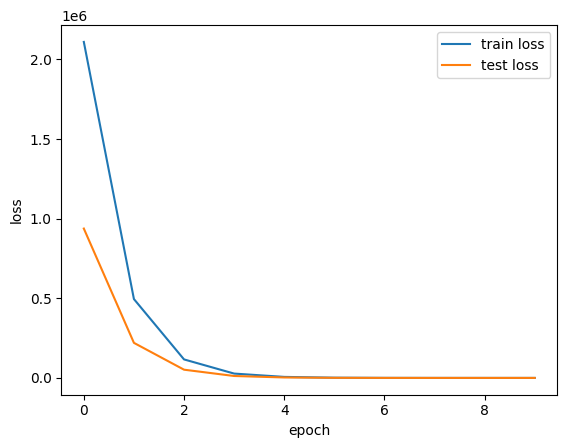

In [ ]:

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(final_train, label='train loss')
plt.plot(final_val, label='test loss')
plt.legend()
plt.show()

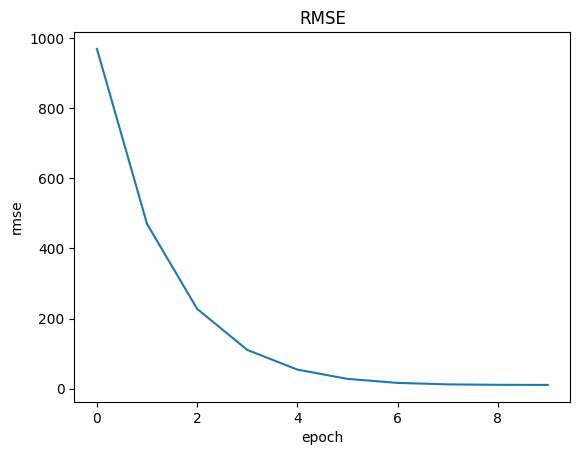

In [ ]:
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.title('RMSE')
plt.plot(final_metrics)
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
# происходит путаница с названиями, поэтому лучше еще раз здесь продублирую

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
class My_Dataset(torch.utils.data.Dataset): # код взят с семинара
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [ ]:
train_set = My_Dataset(X_train_scaled, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = My_Dataset(X_test_scaled, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# пока что возьму простую модель из семинара с двумя линейными слоями а функцией активации ReLU

model = nn.Sequential(
      nn.Linear(X_train.shape[1], 45),
      nn.ReLU(),
      nn.Linear(45, 1)
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_final = []
    for epoch in range(10):
        train_loss = []
        for i, batch in enumerate(train_loader):
            x_train, y_train = batch['sample'], batch['target'].to(torch.float)
            y_pred = model(x_train.to(device))
            loss = criterion(y_pred, y_train.to(device))
            train_loss.append(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f"Epoch: {epoch}, train loss: {np.mean(train_loss)}")
        train_final.append(np.mean(train_loss))
    return train_final

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    with torch.no_grad():
        test_loss = []
        for j, val_batch in enumerate(test_loader):
            x_val, y_val = val_batch['sample'], val_batch['target']
            y_pred = model(x_val.to(device))
            loss = torch.sqrt(criterion(y_pred, y_val.to(device)))
            test_loss.append(loss.cpu().numpy())
        print(f'rmse: {np.mean(test_loss)}')
    return np.mean(test_loss)
    # так как мы считаем лосс на батче, то и предсказания у нас будут размера батча, поэтому не будем сравнивать размер того, что выдает нам функция test() с размером исходной тестовой выборки. Лучше посмотрим на качество.



In [ ]:
final_train = train(model, optimizer, criterion, train_loader, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train loss: 22582.171875
Epoch: 1, train loss: 1764.928466796875
Epoch: 2, train loss: 887.1199340820312
Epoch: 3, train loss: 414.8829040527344
Epoch: 4, train loss: 310.7047424316406
Epoch: 5, train loss: 212.1833953857422
Epoch: 6, train loss: 213.10877990722656
Epoch: 7, train loss: 202.93165588378906
Epoch: 8, train loss: 198.88858032226562
Epoch: 9, train loss: 175.8437042236328


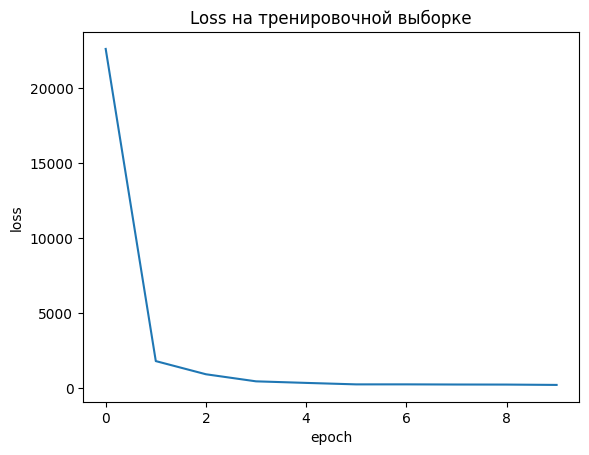

In [ ]:
plt.title('Loss на тренировочной выборке')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(final_train)
plt.show()

In [ ]:
test(model, criterion, test_loader)

rmse: 10.945951461791992


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


10.945951

Не самая лучшая архитектура. Качество ниже, чем в предыдущем задании с одним линейный слоем. Попробуем подобрать гиперпараметр lr.

In [ ]:
losses = []
print(losses)
for step in [0.000001, 0.00001, 0.0001]:
    train_set = My_Dataset(X_train_scaled, y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

    test_set = My_Dataset(X_test_scaled, y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

    model = nn.Sequential(
          nn.Linear(X_train.shape[1], 45),
          nn.ReLU(),
          nn.Linear(45, 1)
          ).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=step)
    criterion = torch.nn.MSELoss()
    train(model, optimizer, criterion, train_loader, test_loader)
    losses.append(test(model, criterion, test_loader))

[]
Epoch: 0, train loss: 527038.8125
Epoch: 1, train loss: 1290.17578125
Epoch: 2, train loss: 361.7490234375
Epoch: 3, train loss: 221.7011260986328
Epoch: 4, train loss: 176.96949768066406
Epoch: 5, train loss: 157.5982666015625
Epoch: 6, train loss: 147.27793884277344
Epoch: 7, train loss: 141.01046752929688
Epoch: 8, train loss: 136.76629638671875
Epoch: 9, train loss: 133.7188720703125
rmse: 10.381719589233398
Epoch: 0, train loss: 54677.92578125
Epoch: 1, train loss: 149.18621826171875
Epoch: 2, train loss: 127.37251281738281
Epoch: 3, train loss: 123.49671936035156
Epoch: 4, train loss: 122.24486541748047
Epoch: 5, train loss: 121.45977783203125
Epoch: 6, train loss: 121.05802917480469
Epoch: 7, train loss: 120.77581787109375
Epoch: 8, train loss: 120.69970703125
Epoch: 9, train loss: 120.45472717285156
rmse: 9.706402778625488
Epoch: 0, train loss: 9445.283203125
Epoch: 1, train loss: 306.7610778808594
Epoch: 2, train loss: 813.2506103515625
Epoch: 3, train loss: 303.00909423828

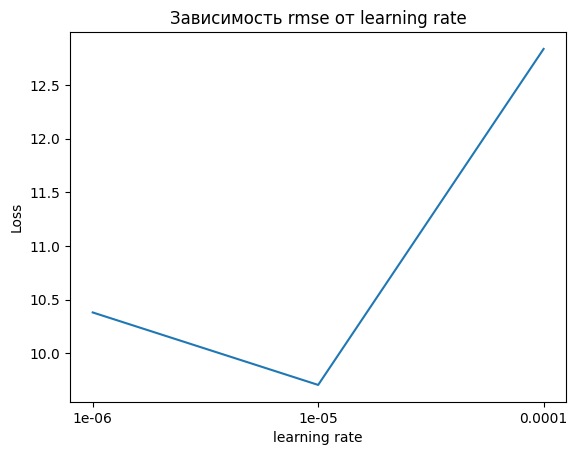

In [ ]:
plt.title('Зависимость rmse от learning rate')
plt.xlabel('learning rate')
plt.ylabel('Loss')
plt.xticks(ticks=[0, 1, 2], labels=[0.000001, 0.00001, 0.0001])
plt.plot(losses)
plt.show()

Посмотрели на размер метрики при разных значениях learning rate, так как мы всегда выводим среднюю ошибку по батчам на всех десяти эпохах, мы видим, что при слишком маленьком шаге градиент у нас очень медленно сходится и не доходит за заданное количество итераций до минимума (или просто самоого маленького значения, которое возможно при такой архитектуре). При lr = 0.00001 путь градиента является оптимальным, а при lr = 0.0001 при приближении к минимуму градиент не может сойтись до значения, до которого он доходил в предыдущем случае. При больших значениях лоссы улетают в наны. (НАПИСАТЬ ПОЧЕМУ). Однако это самое простое, что мы можем сделать с шагом градиента. В SGD оптимайзере есть параметр momentum, который помогает улучшить и ускорить сходимость градиента, так как накапливает информацию о предыдщуих итерациях. В статье https://medium.com/analytics-vidhya/hyper-parameters-tuning-practices-learning-rate-batch-size-momentum-and-weight-decay-4b30f3c19ae8 советуют рассмотреть значения этого гиперпараметра, равные 0.9, 0.95, 0.97, 0.99. Однако я пробовала много значений и не могу сказать, что эти значения самые оптимальные. Скорее всего потому что в статье расматривают общие случаи: более сложные архитектуры, где пристуствуют не только линейные слои. Поэтому рассмотрим разные значения и выберем тот, который подходит именно для нашего случая. Чем больше этот гиперпараметр, тем быстрее сходится градиент.

In [ ]:
losses_2 = []
for momentum in [0.5, 0.7, 0.9, 0.95]:
    train_set = My_Dataset(X_train_scaled, y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

    test_set = My_Dataset(X_test_scaled, y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

    model = nn.Sequential(
          nn.Linear(X_train.shape[1], 45),
          nn.ReLU(),
          nn.Linear(45, 1)
          ).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=momentum)
    criterion = torch.nn.MSELoss()
    train(model, optimizer, criterion, train_loader, test_loader)
    losses_2.append(test(model, criterion, test_loader))

Epoch: 0, train loss: 28890.205078125
Epoch: 1, train loss: 140.09188842773438
Epoch: 2, train loss: 127.40006256103516
Epoch: 3, train loss: 121.70330047607422
Epoch: 4, train loss: 120.90784454345703
Epoch: 5, train loss: 120.65397644042969
Epoch: 6, train loss: 120.44147491455078
Epoch: 7, train loss: 120.39492797851562
Epoch: 8, train loss: 120.31407165527344
Epoch: 9, train loss: 120.25086975097656
rmse: 9.95572280883789
Epoch: 0, train loss: 24858.109375
Epoch: 1, train loss: 328.7634582519531
Epoch: 2, train loss: 178.54286193847656
Epoch: 3, train loss: 147.703857421875
Epoch: 4, train loss: 133.55294799804688
Epoch: 5, train loss: 122.462890625
Epoch: 6, train loss: 120.91426086425781
Epoch: 7, train loss: 120.59038543701172
Epoch: 8, train loss: 120.47557067871094
Epoch: 9, train loss: 120.45156860351562
rmse: 9.659466743469238
Epoch: 0, train loss: 17172.384765625
Epoch: 1, train loss: 314.58282470703125
Epoch: 2, train loss: 264.65191650390625
Epoch: 3, train loss: 229.1711

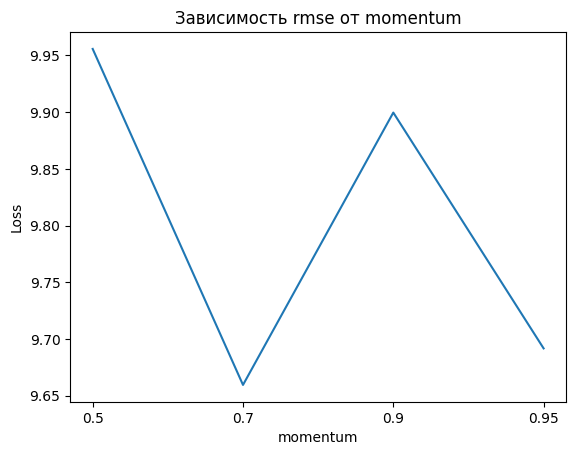

In [ ]:
plt.title('Зависимость rmse от momentum')
plt.xlabel('momentum')
plt.ylabel('Loss')
plt.xticks(ticks=[0, 1, 2, 3], labels=[0.5, 0.7, 0.9, 0.95])
plt.plot(losses_2)
plt.show()

Самое низкое значение rmse получилось при momentum = 0.7. Качество все же значительно не изменяется, попробуем поэкспериментировать с количеством нейронов в скрытых слоях. Я нашла статью, где из разных исследований сделали вывод о разных оптимальных значениях числа нейронов в скрытых слоях. В начале у меня это число равно 45 (90/2), так как имеется такой совет: "The number of hidden neurons should be less than twice the size of the input layer". Также есть такая рекомендация: "The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer". Попробуем число нейронов равное 90 * (2/3) + 1 = 61. Статья: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3

In [ ]:
# происходит путаница с названиями, поэтому лучше еще раз здесь продублирую

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
train_set = My_Dataset(X_train_scaled, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = My_Dataset(X_test_scaled, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

model = nn.Sequential(
      nn.Linear(X_train.shape[1], 61),
      nn.ReLU(),
      nn.Linear(61, 1)
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.7)
criterion = torch.nn.MSELoss()

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_final = []
    for epoch in range(10):
        train_loss = []
        for i, batch in enumerate(train_loader):
            x_train, y_train = batch['sample'], batch['target'].to(torch.float)
            y_pred = model(x_train.to(device))
            loss = criterion(y_pred, y_train.to(device))
            train_loss.append(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f"Epoch: {epoch}, train loss: {np.mean(train_loss)}")
        train_final.append(np.mean(train_loss))
    return train_final

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    with torch.no_grad():
        test_loss = []
        for j, val_batch in enumerate(test_loader):
            x_val, y_val = val_batch['sample'], val_batch['target']
            y_pred = model(x_val.to(device))
            loss = torch.sqrt(criterion(y_pred, y_val.to(device)))
            test_loss.append(loss.cpu().numpy())
        print(f'rmse: {np.mean(test_loss)}')

    # так как мы считаем лосс на батче, то и предсказания у нас будут размера батча, поэтому не будем сравнивать размер того, что выдает нам функция test() с размером исходной тестовой выборки. Лучше посмотрим на качество.



In [ ]:
final_train = train(model, optimizer, criterion, train_loader, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train loss: 21521.23046875
Epoch: 1, train loss: 176.37442016601562
Epoch: 2, train loss: 190.54946899414062
Epoch: 3, train loss: 188.5045166015625


In [ ]:
test(model, criterion, test_loader)

In [ ]:
plt.title('Loss на тренировочной выборке')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(final_train)
plt.show()

Лучше не стало, стало чуть хуже. Но качество все же не меняется значительно. Попробуем отнормировать таргет, как рекомендовалось в задании.

In [ ]:
# происходит путаница с названиями, поэтому лучше еще раз здесь продублирую

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

train_set = My_Dataset(X_train_scaled, y_train_scaled)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = My_Dataset(X_test_scaled, y_test_scaled)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

model = nn.Sequential(
      nn.Linear(X_train.shape[1], 45),
      nn.ReLU(),
      nn.Linear(45, 1)
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_final = []
    for epoch in range(10):
        train_loss = []
        for i, batch in enumerate(train_loader):
            x_train, y_train = batch['sample'], batch['target'].to(torch.float)
            y_pred = model(x_train.to(device))
            loss = criterion(y_pred, y_train.to(device))
            train_loss.append(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f"Epoch: {epoch}, train loss: {np.mean(train_loss)}")
        train_final.append(np.mean(train_loss))
    return train_final

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    with torch.no_grad():
        test_loss = []
        for j, val_batch in enumerate(test_loader):
            x_val, y_val = val_batch['sample'], val_batch['target']
            y_pred = model(x_val.to(device))
            y_val = torch.from_numpy(target_scaler.inverse_transform(y_val))
            y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred))
            loss = torch.sqrt(criterion(y_pred, y_val.to(device)))
            test_loss.append(loss.cpu().numpy())
        print(f'rmse: {np.mean(test_loss)}')

    # так как мы считаем лосс на батче, то и предсказания у нас будут размера батча, поэтому не будем сравнивать размер того, что выдает нам функция test() с размером исходной тестовой выборки. Лучше посмотрим на качество.



In [ ]:
final_train = train(model, optimizer, criterion, train_loader, test_loader)

Epoch: 0, train loss: 0.9811432957649231
Epoch: 1, train loss: 0.9218115210533142
Epoch: 2, train loss: 0.884279727935791
Epoch: 3, train loss: 0.8546460270881653
Epoch: 4, train loss: 0.8303874135017395
Epoch: 5, train loss: 0.8105705380439758
Epoch: 6, train loss: 0.7946363687515259
Epoch: 7, train loss: 0.781704306602478
Epoch: 8, train loss: 0.7711099982261658
Epoch: 9, train loss: 0.7623227834701538


In [ ]:
test(model, criterion, test_loader)

rmse: 8.562826614877302


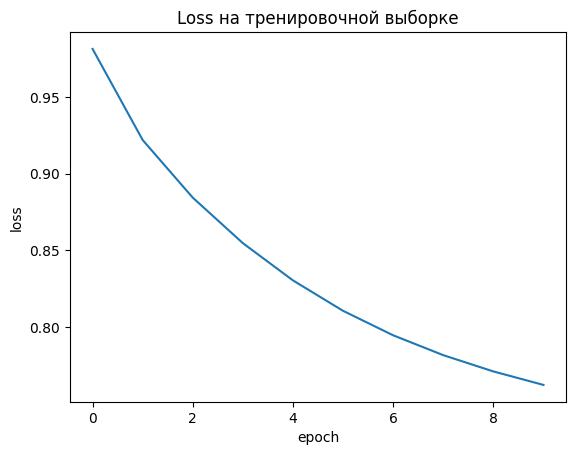

In [ ]:
plt.title('Loss на тренировочной выборке')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(final_train)
plt.show()

Лосс такой маленький, так как таргет отнормирован. Вроде бы модель не переобучается. Можем остановиться на этом.

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1. Сама модель получилась несложная, состоит из двух линейных слоев и функции активации ReLU. Функция активации, оптимизатор SGD и функция потерь MSE Loss были выбрана исходя из здравого смысла и того, что написано в статьях:
- https://medium.com/@learnwithwhiteboard_digest/8-tips-on-how-to-choose-neural-network-architecture-e50590e99ab1
- https://towardsdatascience.com/-a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b
- https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fodsc.medium.com%2Fguidelines-for-choosing-an-optimizer-and-loss-functions-when-training-neural-networks-efcf97b7aa2
Если коротко, то MSE подходит для задачи регрессии и наши даннеы не содержат выбросов. Оптимизатор SGD и функция активации ReLU наиболее часто используются и хорошо показывают себя на всех задачах, тем более с градиентным спуском мы уже много работали и знаем про его разные модификации.  
2. Далее я подбирала гиперпараметры learning rate и momentum. Про последний нам также рассказывали на лекции, и мне было интересно его попробовать.
3. Посмотрела на разные значения числа нейронов (отталкивалась от того, что пишут в статьях)
4. Отнормировала таргет, что значительно улучшило качество.
5. Извините, что каждый раз дублировала код, знаю, что некоторые куски можно было не дублировать, но у меня один раз случилась ошибка из-за того, что тренировалась с другим массивом, и я не могла найти ошибку около 3 часов, так что решила не рисковать больше.